# 1) Data Exploration

In [2]:
import urllib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import PIL

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')

## 1.1) Load Data

- As a Data Scientist, you don't have access to the full data set, only the 100k on which you've been tasked to train & fine-tune the best model
- As an ML Engineer, you'll have access to the full data set later, but not for this notebook

In [247]:
DATA_URL = "~/.lewagon/mlops/data/raw/train_1k.csv"
df = pd.read_csv(DATA_URL)

In [248]:
print('testing')

testing


In [249]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-12-05 10:58:03.0000005,5.7,2009-12-05 10:58:03 UTC,-73.986105,40.726468,-74.003967,40.729337,1
1,2014-02-19 21:42:16.0000004,15.5,2014-02-19 21:42:16 UTC,-73.986020,40.756367,-73.960374,40.799972,1
2,2011-10-08 11:36:00.00000025,17.7,2011-10-08 11:36:00 UTC,-74.014813,40.711205,-74.014813,40.711205,5
3,2011-11-03 14:23:36.0000005,5.7,2011-11-03 14:23:36 UTC,-73.966900,40.772800,-73.974000,40.763100,2
4,2010-12-13 21:00:18.0000009,6.1,2010-12-13 21:00:18 UTC,-74.001170,40.718877,-74.014814,40.709513,1


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                1000 non-null   object 
 1   fare_amount        1000 non-null   float64
 2   pickup_datetime    1000 non-null   object 
 3   pickup_longitude   1000 non-null   float64
 4   pickup_latitude    1000 non-null   float64
 5   dropoff_longitude  1000 non-null   float64
 6   dropoff_latitude   1000 non-null   float64
 7   passenger_count    1000 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 62.6+ KB


### 1.1.1) Compress Data

Let's compress our DataFrame by lowering its numeric `dtypes`
- from  `float64` to `float32`
- from `int64` to `int8`

To do so, we iterate on its columns, and for each one, reduce its `dtypes` as much as possible using [`pd.to_numeric`](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html)

**💡 1) Read more about `dtype` compression in the ML Ops - Train at Scale lecture on Kitt, "Appendix A1: Memory Optimization"**

**💡 2) Then, understand and execute the following code**

In [251]:
def compress(df, **kwargs):
    """
    Reduces the size of the DataFrame by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024**2
    print("old dataframe size: ", round(input_size,2), 'MB')
    
    in_size = df.memory_usage(index=True).sum()

    for t in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=t))

        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=t)

    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100
    
    print("optimized size by {} %".format(round(ratio,2)))
    print("new DataFrame size: ", round(out_size / 1024**2,2), " MB")

    return df

In [252]:
df = compress(df, verbose=True)
df.head(1)

old dataframe size:  0.06 MB
optimized size by 42.0 %
new DataFrame size:  0.04  MB


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-12-05 10:58:03.0000005,5.7,2009-12-05 10:58:03 UTC,-73.986107,40.726467,-74.003967,40.729336,1


Let's check dtypes optimized

In [253]:
df.dtypes

key                   object
fare_amount          float32
pickup_datetime       object
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count         int8
dtype: object

We can force an optimal dtype directly at loading time to minimize RAM

In [254]:
DTYPES_RAW_OPTIMIZED = {
    "key": "O",
    "fare_amount": "float32",
    "pickup_datetime": "O",
    "pickup_longitude": "float32",
    "pickup_latitude": "float32",
    "dropoff_longitude": "float32",
    "dropoff_latitude": "float32",
    "passenger_count": "int8"
}

df = pd.read_csv(DATA_URL, dtype=DTYPES_RAW_OPTIMIZED)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                1000 non-null   object 
 1   fare_amount        1000 non-null   float32
 2   pickup_datetime    1000 non-null   object 
 3   pickup_longitude   1000 non-null   float32
 4   pickup_latitude    1000 non-null   float32
 5   dropoff_longitude  1000 non-null   float32
 6   dropoff_latitude   1000 non-null   float32
 7   passenger_count    1000 non-null   int8   
dtypes: float32(5), int8(1), object(2)
memory usage: 36.3+ KB


## 1.2) Clean Data

In [255]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,10.990510,-72.085754,39.657570,-72.231537,39.738605,1.684000
std,8.478097,11.877452,7.202527,11.430066,6.980386,1.282883
min,2.500000,-74.046127,-73.983032,-74.035606,-73.986137,0.000000
25%,6.000000,-73.992401,40.733700,-73.991108,40.732603,1.000000
50%,8.500000,-73.982029,40.752527,-73.979809,40.752590,1.000000
75%,12.900000,-73.966516,40.765712,-73.961905,40.769646,2.000000
max,60.500000,40.766685,40.860451,40.757992,40.905136,6.000000


In [256]:
df.shape

(1000, 8)

In [257]:
# remove redundant columns or rows
df = df.drop(columns=['key'])
df = df.drop_duplicates()
df.shape

(1000, 7)

In [258]:
df = df.dropna(how='any', axis=0)
df.shape

(1000, 7)

In [259]:
# Remove buggy transactions
df = df[(df.dropoff_latitude != 0) | (df.dropoff_longitude != 0) | (df.pickup_latitude != 0) | (df.pickup_longitude != 0)]
df = df[df.passenger_count > 0]
df = df[df.fare_amount > 0]
df.shape

(975, 7)

Let's check NYC bouding boxes

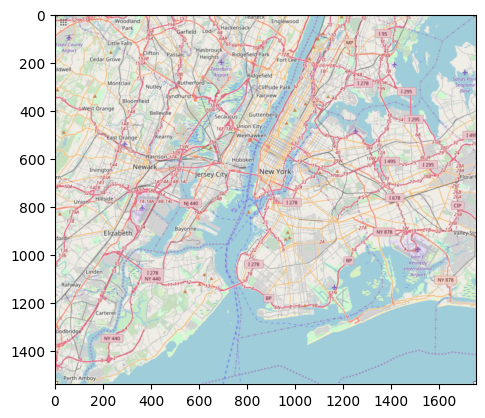

In [260]:
# Load image of NYC map
bounding_boxes = (-74.3, -73.7, 40.5, 40.9)

url = 'https://wagon-public-datasets.s3.amazonaws.com/data-science-images/07-ML-OPS/nyc_-74.3_-73.7_40.5_40.9.png'
nyc_map = np.array(PIL.Image.open(urllib.request.urlopen(url)))

plt.imshow(nyc_map);

In [261]:
# Remove irrelevant/non-representative transactions (rows) for a training set
df = df[df["pickup_latitude"].between(left=40.5, right=40.9)]
df = df[df["dropoff_latitude"].between(left=40.5, right=40.9)]
df = df[df["pickup_longitude"].between(left=-74.3, right=-73.7)]
df = df[df["dropoff_longitude"].between(left=-74.3, right=-73.7)]

In [262]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000
mean,10.928391,-73.976189,40.750282,-73.974182,40.751190,1.701031
std,8.333247,0.033574,0.027842,0.031282,0.031469,1.293510
min,2.500000,-74.046127,40.641853,-74.035606,40.593414,1.000000
25%,6.000000,-73.992710,40.735794,-73.991310,40.734472,1.000000
50%,8.500000,-73.982288,40.753532,-73.980240,40.753248,1.000000
75%,12.900000,-73.968260,40.766013,-73.963514,40.769949,2.000000
max,60.500000,-73.776810,40.860451,-73.763527,40.885849,6.000000


In [263]:
# Let's cap training set to reasonable values 
df = df[df.fare_amount < 400]
df = df[df.passenger_count < 8]

In [264]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,5.700000,2009-12-05 10:58:03 UTC,-73.986107,40.726467,-74.003967,40.729336,1
1,15.500000,2014-02-19 21:42:16 UTC,-73.986023,40.756367,-73.960373,40.799973,1
2,17.700001,2011-10-08 11:36:00 UTC,-74.014816,40.711205,-74.014816,40.711205,5
3,5.700000,2011-11-03 14:23:36 UTC,-73.966904,40.772800,-73.973999,40.763100,2
4,6.100000,2010-12-13 21:00:18 UTC,-74.001167,40.718876,-74.014816,40.709515,1
...,...,...,...,...,...,...,...
995,6.500000,2014-01-11 16:16:00 UTC,-73.988052,40.759201,-74.002792,40.760509,2
996,12.500000,2010-09-13 08:41:09 UTC,-73.992172,40.725231,-73.996620,40.737328,1
997,5.500000,2012-12-22 21:28:00 UTC,-73.976593,40.765610,-73.982399,40.775169,1
998,22.500000,2013-11-14 07:23:26 UTC,-74.013458,40.709026,-73.988640,40.758286,1


## 1.3) Visualize Data

Text(0.5, 1.0, 'Histogram')

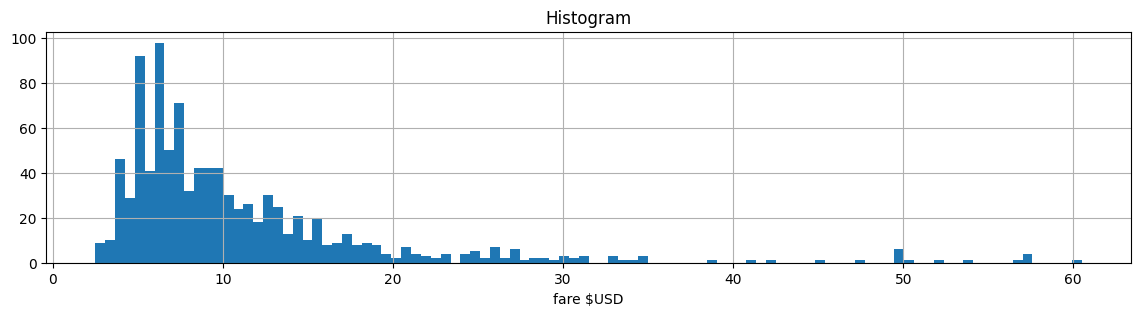

In [265]:
# Plot histogram of fare
df.fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')

In [266]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))

    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='red', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='blue', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

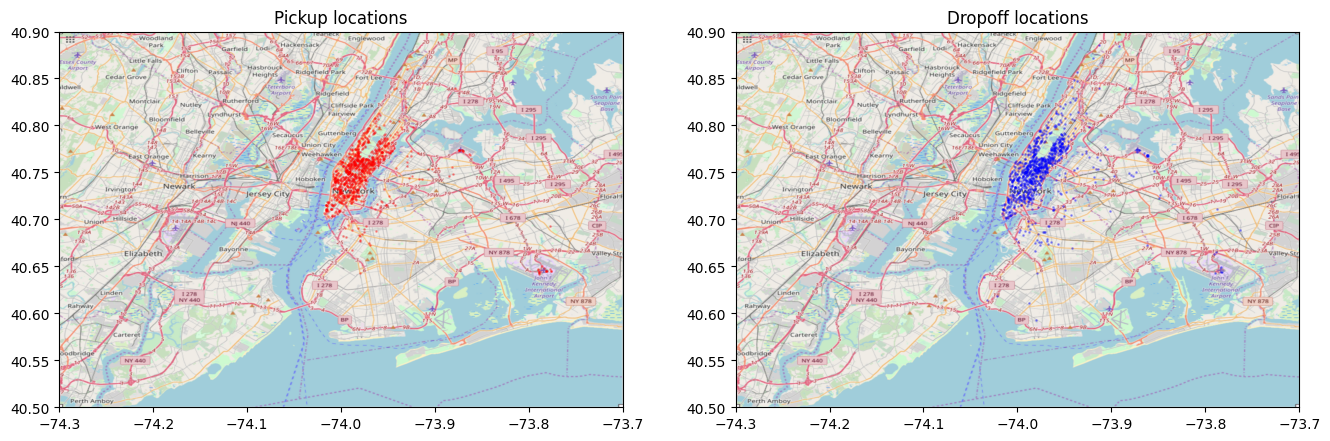

In [267]:
# Plot training data on map
plot_on_map(df, bounding_boxes, nyc_map, s=1, alpha=0.3)

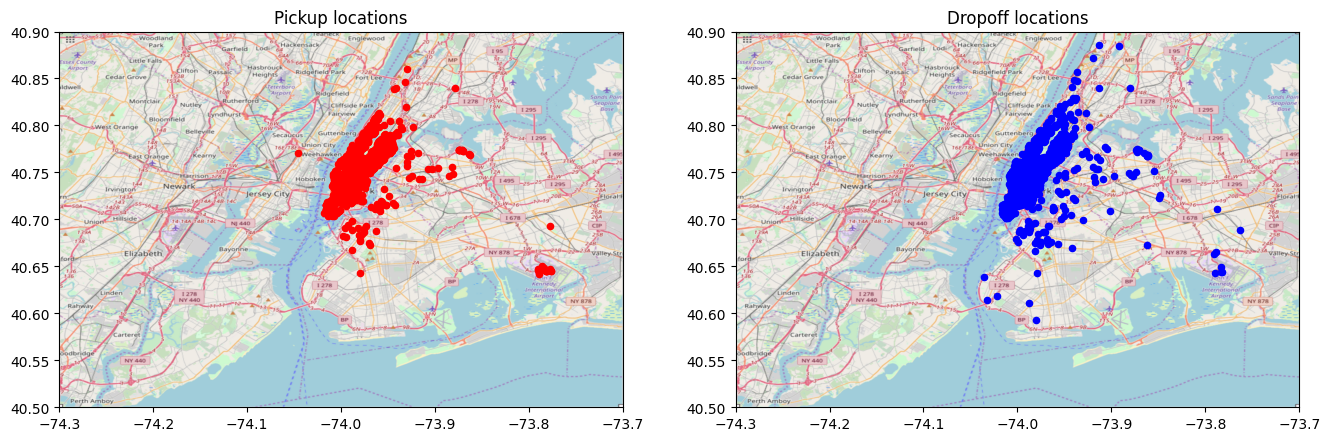

In [268]:
plot_on_map(df, bounding_boxes, nyc_map, s=20, alpha=1.0)

In [269]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    def select_within_boundingbox(df, BB):
        return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
            (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
            (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
            (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c="red", s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c="blue", s=0.01, alpha=0.5)

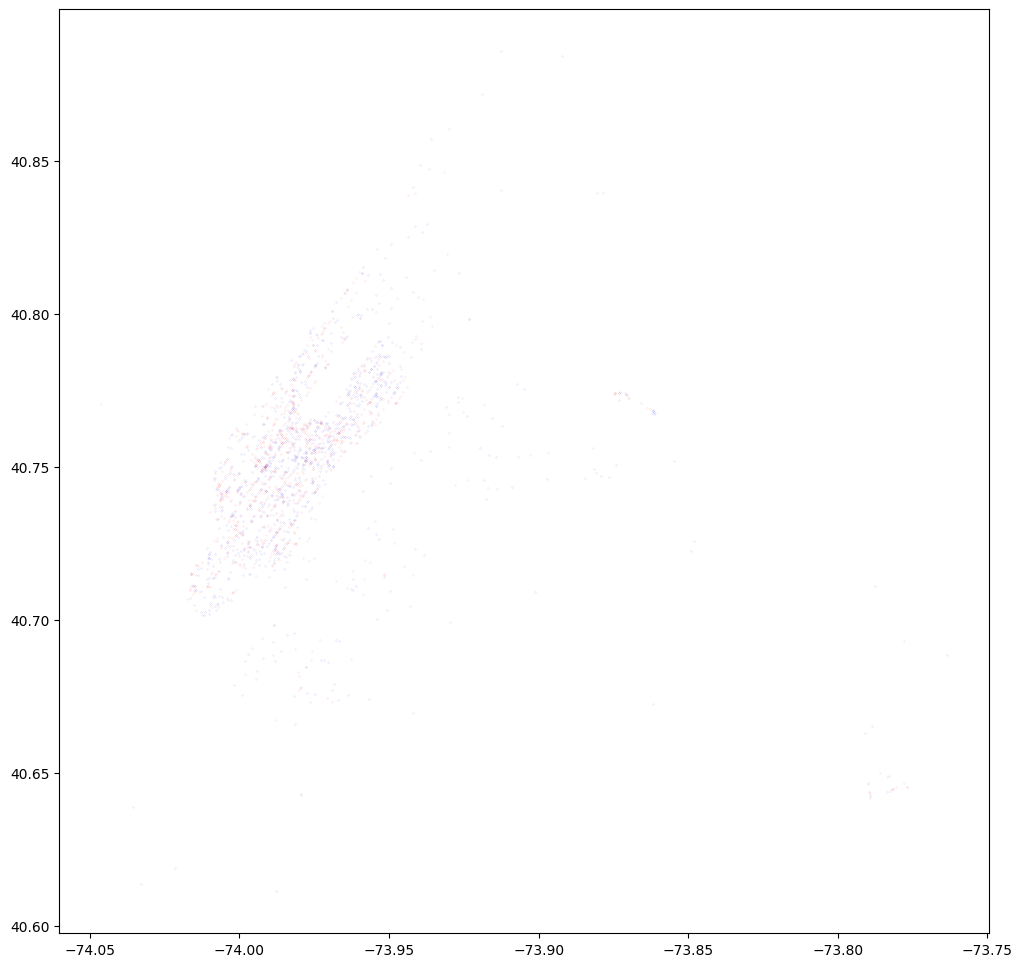

In [270]:
plot_hires(df, (-74.1, -73.7, 40.6, 40.9))

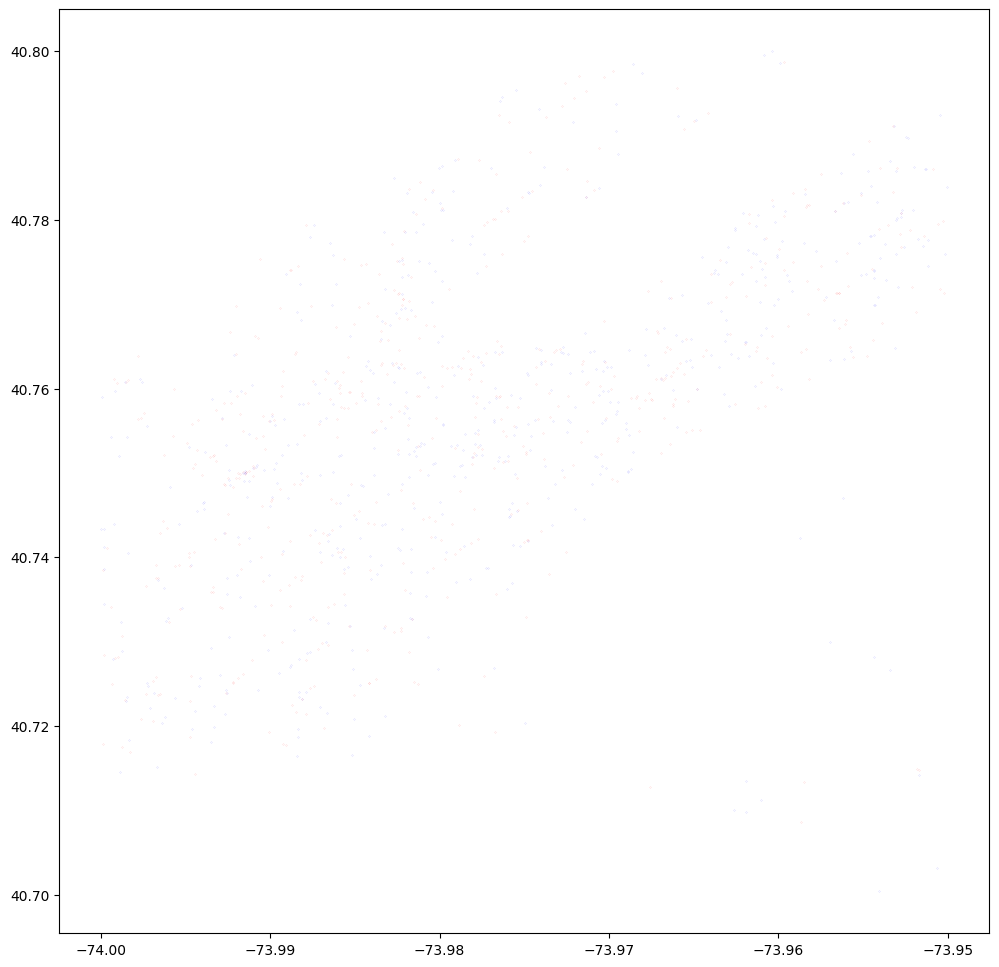

In [271]:
plot_hires(df, (-74, -73.95, 40.7, 40.8))

### 1.4) Baseline Score  - Preliminary Intuitions

A baseline model should at least take into account the most obvious feature: the distance between `pickup` and `dropoff`.

The correct distance metric is appropriately named "Manhattan distance" (L1 distance), which computes the sum of horizontal and vertical distances between two points, instead of the diagonal (Euclidean, L2) distance.

In [272]:
import math

def manhattan_distance(start_lat: float, start_lon: float, end_lat: float, end_lon: float) -> float:
    """
    Calculate the Manhattan distance between in km two points on the earth (specified in decimal degrees).
    """
    earth_radius = 6371
    
    lat_1_rad, lon_1_rad = math.radians(start_lat), math.radians(start_lon)
    lat_2_rad, lon_2_rad = math.radians(end_lat), math.radians(end_lon)
    
    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad
    
    manhattan_rad = abs(dlon_rad) + abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius
    
    return manhattan_km

In [273]:
df.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,5.7,2009-12-05 10:58:03 UTC,-73.986107,40.726467,-74.003967,40.729336,1
1,15.5,2014-02-19 21:42:16 UTC,-73.986023,40.756367,-73.960373,40.799973,1


In [274]:
%%time
df.apply(lambda row: manhattan_distance(row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)

CPU times: user 22.9 ms, sys: 1.56 ms, total: 24.4 ms
Wall time: 23.6 ms


0      2.304967
1      7.700897
2      0.000000
3      1.867642
4      2.558623
         ...   
995    1.784504
996    1.839647
997    1.708577
998    8.237054
999    2.341022
Length: 970, dtype: float64

☝️ The following code takes a while and is not optimized.

Applying a mapping function row-by-row on a DataFrame is a very bad engineering practice, as DataFrames are stored in memory "column-by-column". We talk about "column-major" data storage formats. 

`df.apply(..., axis=1)` is equivalent to a python `for` loop, and does not harness NumPy's vectorized operations.

👇 Let's vectorize our code instead! Notice the improvement by a factor of several hundred 💪

In [275]:
def manhattan_distance_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the Manhattan distance in km between two points on the earth (specified in decimal degrees).
    Vectorized version for pandas df
    """
    earth_radius = 6371
    
    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])
    
    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad
    
    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius
    
    return manhattan_km

In [276]:
%%time
manhattan_distance_vectorized(df, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude")

CPU times: user 2.71 ms, sys: 856 µs, total: 3.57 ms
Wall time: 4.54 ms


0      2.305029
1      7.700392
2      0.000000
3      1.867947
4      2.559076
         ...   
995    1.784404
996    1.839466
997    1.708835
998    8.237346
999    2.341105
Length: 970, dtype: float32

Text(0.5, 1.0, 'distance (km)')

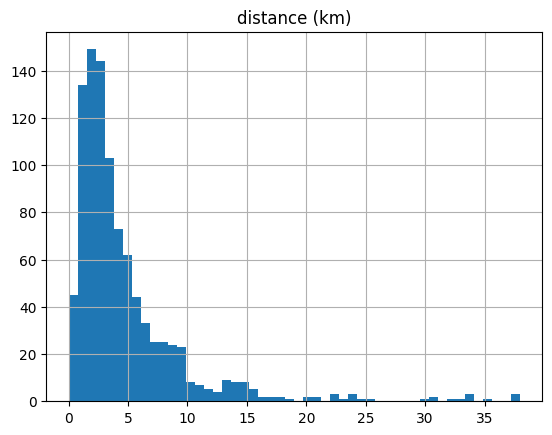

In [277]:
df['distance'] = manhattan_distance_vectorized(df, "pickup_latitude", "pickup_longitude","dropoff_latitude", "dropoff_longitude")
df['distance'].hist(bins=50)
plt.title("distance (km)")

<AxesSubplot: xlabel='distance', ylabel='fare_amount'>

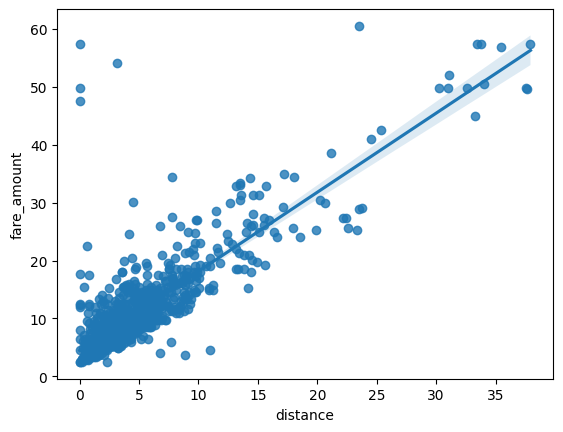

In [278]:
sns.regplot(data=df, x='distance', y='fare_amount')

In [279]:
from scipy.stats import pearsonr

pearson, p_value = pearsonr(df['distance'], df['fare_amount'])
print(f'{pearson=}')
print(f'{p_value=}')

pearson=0.8399872950955908
p_value=2.921243208864543e-259


In [280]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

mae = -1*cross_val_score(LinearRegression(), X=df[['distance']], y=df['fare_amount'], scoring='neg_mean_absolute_error').mean()
print(f'baseline mae = {round(mae,2)} $')

baseline mae = 2.55 $


☝️ We've got our baseline! 

Let's drop the `distance` column we added manually, and create a true preprocessing pipeline now

In [281]:
df = df.drop(columns=['distance'])
df.shape

(970, 7)

# 2) Preprocessing

We are given a dataset with only 5 features (passengers + lon/lat), and potentially dozens of millions of rows.

👉 It makes perfect sense to create a lot of "engineered" features such as "hour of the day"  
- Hundreds of them would cause no problem because the huge number of rows will allow our model to learn all weights associated with these multiple features
- A dense, Deep Learning network will be well-suited for such a case

❗️ The proposed preprocessor below outputs a **fixed number of features** (65) that is **independent of the training set**. You will see that it will come in handy when scaling it up to hundreds of millions of rows

In [282]:
X = df.drop("fare_amount", axis=1)
y = df[["fare_amount"]]

In [283]:
X.head(1)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-12-05 10:58:03 UTC,-73.986107,40.726467,-74.003967,40.729336,1


In [284]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [285]:
X_train

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
313,2010-01-30 16:04:00 UTC,-73.971329,40.795265,-73.992958,40.726040,2
206,2013-06-11 16:19:13 UTC,-73.984215,40.744015,-73.970291,40.763287,2
622,2014-08-10 17:04:00 UTC,-73.989159,40.758434,-74.004379,40.730968,2
232,2012-09-14 14:26:00 UTC,-73.930122,40.761044,-73.990044,40.751808,2
957,2014-06-02 10:31:54 UTC,-73.978119,40.761749,-73.984634,40.748508,3
...,...,...,...,...,...,...
196,2011-02-25 19:57:06 UTC,-73.982300,40.748024,-73.953667,40.772827,1
438,2012-01-14 10:34:28 UTC,-73.991150,40.742195,-74.000519,40.747856,1
58,2013-12-15 13:00:00 UTC,-73.975922,40.791557,-73.980461,40.783249,2
121,2013-02-04 19:04:37 UTC,-73.982407,40.757282,-73.977051,40.758354,3


## 2.1) Passenger Preprocessors

Let's analyze passenger numbers

<AxesSubplot: xlabel='passenger_count', ylabel='Count'>

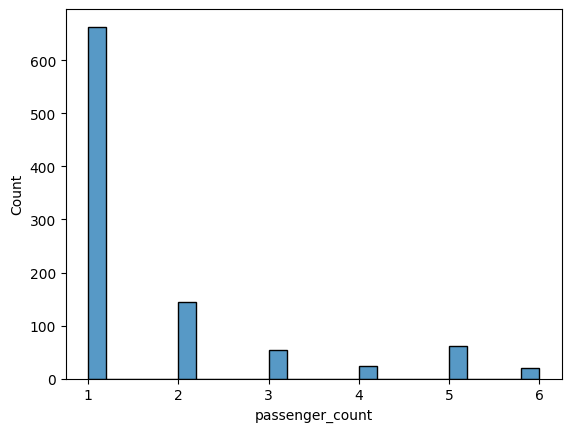

In [286]:
sns.histplot(df.passenger_count)

In [287]:
# PASSENGER PIPE
p_min = 1
p_max = 8
passenger_pipe = FunctionTransformer(lambda p: (p-p_min)/(p_max-p_min))

In [288]:
preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
    ],
)
preprocessor

ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x154152200>),
                                 ['passenger_count'])])

In [289]:
pd.DataFrame(preprocessor.fit_transform(X_train))

,0
0,0.142857
1,0.142857
2,0.142857
3,0.142857
4,0.285714
...,...
674,0.000000
675,0.000000
676,0.142857
677,0.285714


## 2.2) Time Preprocessor

First, let's extract category attributes from the `pickup_datetime`

In [290]:
import math

def transform_time_features(X: pd.DataFrame) -> np.ndarray:
    assert isinstance(X, pd.DataFrame)

    pickup_dt = pd.to_datetime(
        X["pickup_datetime"],
        format="%Y-%m-%d %H:%M:%S UTC",
        utc=True
    )

    pickup_dt = pickup_dt.dt.tz_convert("America/New_York").dt

    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month
    year = pickup_dt.year

    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2*math.pi / 24 * hour)
    
    return np.stack([hour_sin, hour_cos, dow, month, year], axis=1)

X_time_processed = transform_time_features(X[["pickup_datetime"]])

x_time_df = pd.DataFrame(X_time_processed, columns=["hour_sin", "hour_cos", "dow", "month", "year"]).head()

In [291]:
time_categories = {
        0: np.arange(0, 7, 1),  # days of the week from 0 to 6
        1: np.arange(1, 13, 1)  # months of the year from 1 to 12
    }

time_categories

{0: array([0, 1, 2, 3, 4, 5, 6]),
 1: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])}

Then, one-hot-encode ["day of week", "month"] by forcing all 24*7 combinations of categories to be always present in X_processed (remember we want a fixed size for X_processed at the end)

In [292]:
time_categories = {
        0: np.arange(0, 7, 1),  # days of the week from 0 to 6
        1: np.arange(1, 13, 1)  # months of the year from 1 to 12
    }

OneHotEncoder(categories='auto', sparse=False)\
    .fit_transform(X_time_processed[:,[2,3]]) # column index [2,3] for ['dow', 'month'] !

/Users/bingobango/.pyenv/versions/3.10.6/envs/taxifare-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

And combine this with a re-scaling of the year

In [293]:
pd.DataFrame(X_time_processed, columns=["hour_sin", "hour_cos", "dow", "month", "year"]).head()

,hour_sin,hour_cos,dow,month,year
0,0.965926,0.258819,5.0,12.0,2009.0
1,-0.866025,-0.500000,2.0,2.0,2014.0
2,0.965926,-0.258819,5.0,10.0,2011.0
3,0.500000,-0.866025,3.0,11.0,2011.0
4,-0.866025,-0.500000,0.0,12.0,2010.0


In [294]:
print(df.pickup_datetime.min())
print(df.pickup_datetime.max())

2009-01-02 15:48:00 UTC
2014-12-30 22:17:25 UTC


In [295]:
year_min = 2009
year_max = 2019 # Our model may extend in the future. No big deal if the scaled data extend slightly beyond 1.0

In [296]:
time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories='auto',
            sparse=False,
            handle_unknown="ignore"
        ), [2, 3]), # corresponds to columns ["day of week", "month"], not the other columns

        (FunctionTransformer(lambda year: (year - year_min) / (year_max - year_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
    )
)

preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
    ],
)

preprocessor

ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x154152200>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x154152290>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('onehotencoder',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse=False),
                                                                                   [2,
                                                                                    3]),
                                                                                  ('functiontransformer',
                                                                                   FunctionTransformer(func=<function <lambda> at 0x154151f30>),
                                                                                   [4])]))]),
                                 ['pickup_datetime'])])

/Users/bingobango/.pyenv/versions/3.10.6/envs/taxifare-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


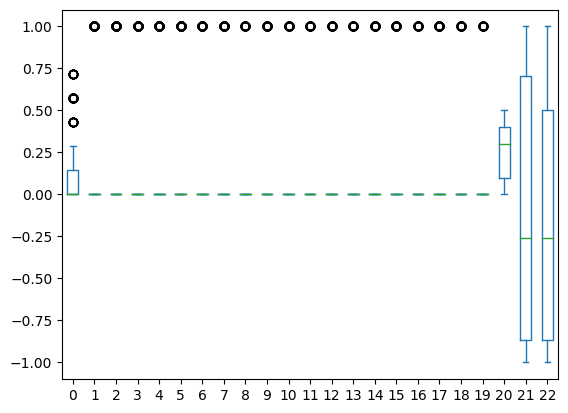

In [297]:
pd.DataFrame(preprocessor.fit_transform(X_train)).plot(kind='box');

☝️ 23 features approximately centered and scaled

## 2.3) Distance Pipeline

Let's add both the haversine and Manhattan distances as features

In [298]:
lonlat_features = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

In [299]:
def distances_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
    """
    Calculate the haversine and Manhattan distances between two points (specified in decimal degrees).
    Vectorized version for pandas df
    Computes distance in Km
    """
    earth_radius = 6371

    lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
    lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

    dlon_rad = lon_2_rad - lon_1_rad
    dlat_rad = lat_2_rad - lat_1_rad

    manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
    manhattan_km = manhattan_rad * earth_radius

    a = (np.sin(dlat_rad / 2.0)**2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon_rad / 2.0)**2)
    haversine_rad = 2 * np.arcsin(np.sqrt(a))
    haversine_km = haversine_rad * earth_radius

    return dict(
        haversine = haversine_km,
        manhattan = manhattan_km
    )

In [300]:
def transform_lonlat_features(X:pd.DataFrame)-> pd.DataFrame:
    assert isinstance(X, pd.DataFrame)
    res = distances_vectorized(X, *lonlat_features)

    return pd.DataFrame(res)

distances = transform_lonlat_features(X[lonlat_features])
distances

,haversine,manhattan
0,1.538490,2.305029
1,5.307726,7.700392
2,0.000000,0.000000
3,1.233318,1.867947
4,1.551662,2.559076
...,...,...
995,1.249928,1.784404
996,1.396250,1.839466
997,1.170291,1.708835
998,5.863068,8.237346


In [301]:
dist_min = 0
dist_max = 100

In [302]:
distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    FunctionTransformer(lambda dist: (dist - dist_min) / (dist_max - dist_min))
    )
distance_pipe

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function transform_lonlat_features at 0x1543e7370>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function <lambda> at 0x1543e71c0>))])

In [303]:
preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
        ("dist_preproc", distance_pipe, lonlat_features),
    ],
)
preprocessor

ColumnTransformer(transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x154152200>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x154152290>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('onehotencod...
                                                                                   FunctionTransformer(func=<function <lambda> at 0x154151f30>),
                                                                                   [4])]))]),
                                 ['pickup_datetime']),
                                ('dist_preproc',
                                 Pipeline(steps=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function transform_lonlat_features at 0x1543e7370>)),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function <lambda> at 0x1543e71c0>))]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude'])])

/Users/bingobango/.pyenv/versions/3.10.6/envs/taxifare-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


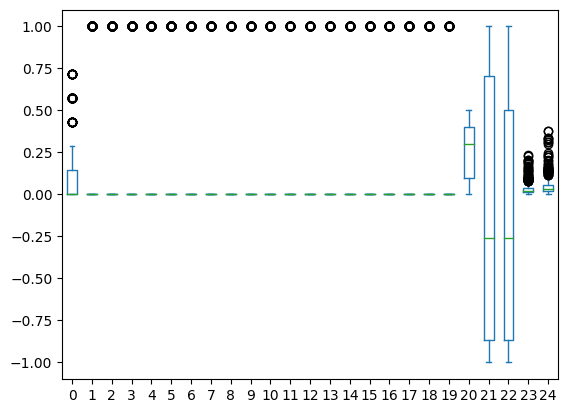

In [304]:
X_processed = pd.DataFrame(preprocessor.fit_transform(X_train))
X_processed.plot(kind='box');

☝️ 25 features, approximately scaled

## 2.4) GeoHasher

Finally, let's add information about **districts**! 

Some might be more expensive than others to go to/depart from (e.g. JFK airport!)

To _bucketize_ geospatial information, we'll use `pygeohash`

In [305]:
import pygeohash as gh

💡 pygeohash converts (lat,lon) into geospacial "squared buckets" of chosen precisions. The more precision you ask, the more "buckets" possibility there is!

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/07-ML-OPS/geohashes.png">

In [306]:
X_train.loc[0]

pickup_datetime      2009-12-05 10:58:03 UTC
pickup_longitude                  -73.986107
pickup_latitude                    40.726467
dropoff_longitude                 -74.003967
dropoff_latitude                   40.729336
passenger_count                            1
Name: 0, dtype: object

In [307]:
X_train.iloc[0,:]

pickup_datetime      2010-01-30 16:04:00 UTC
pickup_longitude                  -73.971329
pickup_latitude                    40.795265
dropoff_longitude                 -73.992958
dropoff_latitude                    40.72604
passenger_count                            2
Name: 313, dtype: object

In [308]:
x0 = X_train.iloc[0,:]
(x0.pickup_latitude, x0.pickup_longitude)

(40.795265, -73.97133)

In [309]:
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=3))
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=4))
print(gh.encode(x0.pickup_latitude, x0.pickup_longitude, precision=5))

dr7
dr72
dr72h


👇 Let's apply it to ALL of our data set (note that this preprocessing may take a very long time!)

In [310]:
def compute_geohash(X:pd.DataFrame, precision:int = 5) -> np.ndarray:
    """
    Add a geohash (ex: "dr5rx") of len "precision" = 5 by default
    corresponding to each (lon, lat) tuple, for pick-up and drop-off
    """
    assert isinstance(X, pd.DataFrame)

    X["geohash_pickup"] = X.apply(
        lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=precision),
        axis=1
    )
    X["geohash_dropoff"] = X.apply(
        lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=precision),
        axis=1
    )

    return X[["geohash_pickup", "geohash_dropoff"]]

In [311]:
compute_geohash(X_train)

,geohash_pickup,geohash_dropoff
313,dr72h,dr5rs
206,dr5ru,dr5ru
622,dr5ru,dr5re
232,dr5rv,dr5ru
957,dr5ru,dr5ru
...,...,...
196,dr5ru,dr5rv
438,dr5ru,dr5ru
58,dr72h,dr72h
121,dr5ru,dr5ru


☝️ Notice that this time, we have no choice but to apply `pygeohash` row by row with `df.apply(axis=1)`, and it takes a while to compute.

This is the danger of relying on an external Python library that is not always vectorized. 

👇 What are the most common districts?

In [312]:
all_geohashes = pd.concat([
    X_train.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=5), axis=1),
    X_train.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=5), axis=1),
])

21


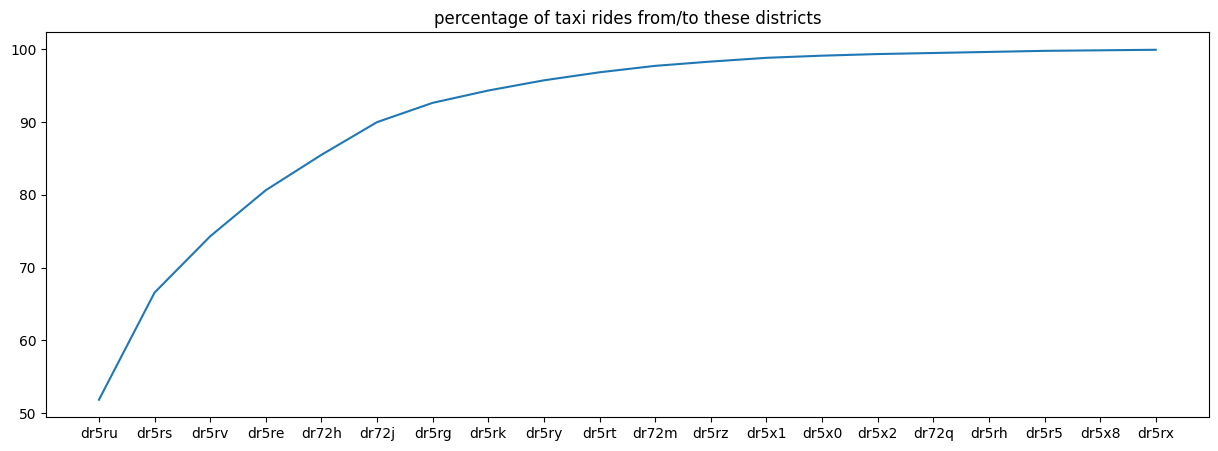

In [313]:
print(len(all_geohashes.value_counts()))
plt.figure(figsize=(15,5))
plt.plot(np.cumsum(all_geohashes.value_counts()[:20])/(2*len(X_train))*100)
plt.title("percentage of taxi rides from/to these districts");

☝️ Only the first 20 districts matter. We can one-hot encode them.

In [314]:
most_important_geohash_districts = np.array(all_geohashes.value_counts()[:20].index)
most_important_geohash_districts

array(['dr5ru', 'dr5rs', 'dr5rv', 'dr5re', 'dr72h', 'dr72j', 'dr5rg',
       'dr5rk', 'dr5ry', 'dr5rt', 'dr72m', 'dr5rz', 'dr5x1', 'dr5x0',
       'dr5x2', 'dr72q', 'dr5rh', 'dr5r5', 'dr5x8', 'dr5rx'], dtype=object)

In [315]:
# Let's hard-code below the 20 most frequent district GeoHashes of precision 5,
# covering about 99% of all dropoff/pickup locations.
most_important_geohash_districts = [
    "dr5ru", "dr5rs", "dr5rv", "dr72h", "dr72j", "dr5re", "dr5rk",
    "dr5rz", "dr5ry", "dr5rt", "dr5rg", "dr5x1", "dr5x0", "dr72m",
    "dr5rm", "dr5rx", "dr5x2", "dr5rw", "dr5rh", "dr5x8"
]

Let's one-hot encode each GeoHash in one of the top-20 different buckets listed above


In [316]:
geohash_categories = {
    0: most_important_geohash_districts,  # pickup district list
    1: most_important_geohash_districts  # dropoff district list
}

geohash_pipe = make_pipeline(
    FunctionTransformer(compute_geohash),
    OneHotEncoder(
        categories=geohash_categories,
        handle_unknown="ignore",
        sparse=False
    )
)
geohash_pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function compute_geohash at 0x1404aaa70>)),
                ('onehotencoder',
                 OneHotEncoder(categories={0: ['dr5ru', 'dr5rs', 'dr5rv',
                                               'dr72h', 'dr72j', 'dr5re',
                                               'dr5rk', 'dr5rz', 'dr5ry',
                                               'dr5rt', 'dr5rg', 'dr5x1',
                                               'dr5x0', 'dr72m', 'dr5rm',
                                               'dr5rx', 'dr5x2', 'dr5rw',
                                               'dr5rh', 'dr5x8'],
                                           1: ['dr5ru', 'dr5rs', 'dr5rv',
                                               'dr72h', 'dr72j', 'dr5re',
                                               'dr5rk', 'dr5rz', 'dr5ry',
                                               'dr5rt', 'dr5rg', 'dr5x1',
                                               'dr5x0', 'dr72m', 'dr5rm',
                                               'dr5rx', 'dr5x2', 'dr5rw',
                                               'dr5rh', 'dr5x8']},
                               handle_unknown='ignore', sparse=False))])

## 2.5) Full Preprocessing Pipeline

Let's recap our final preprocessor

### a) Encoders

In [317]:
import math
import numpy as np
import pandas as pd
import pygeohash as gh

In [318]:
def transform_time_features(X: pd.DataFrame)->np.ndarray:
    assert isinstance(X, pd.DataFrame)
    
    pickup_dt = pd.to_datetime(
        X["pickup_datetime"],
        format="%Y-%m-%d %H:%M:%S UTC",
        utc=True
    )

    pickup_dt = pickup_dt.dt.tz_convert("America/New_York").dt

    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month
    year = pickup_dt.year

    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2*math.pi / 24 * hour)
    
    result = np.stack([hour_sin, hour_cos, dow, month, year], axis=1)

    return result

In [319]:
def transform_lonlat_features(X: pd.DataFrame) -> pd.DataFrame:

    assert isinstance(X, pd.DataFrame)
    lonlat_features = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

    def distances_vectorized(df: pd.DataFrame, start_lat: str, start_lon: str, end_lat: str, end_lon: str) -> dict:
        """
        Calculate the haversine and Manhattan distances between two points on the earth (specified in decimal degrees).
        Vectorized version for pandas df
        Computes distance in Km
        """
        earth_radius = 6371

        lat_1_rad, lon_1_rad = np.radians(df[start_lat]), np.radians(df[start_lon])
        lat_2_rad, lon_2_rad = np.radians(df[end_lat]), np.radians(df[end_lon])

        dlon_rad = lon_2_rad - lon_1_rad
        dlat_rad = lat_2_rad - lat_1_rad

        manhattan_rad = np.abs(dlon_rad) + np.abs(dlat_rad)
        manhattan_km = manhattan_rad * earth_radius

        a = (np.sin(dlat_rad / 2.0)**2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon_rad / 2.0)**2)
        haversine_rad = 2 * np.arcsin(np.sqrt(a))
        haversine_km = haversine_rad * earth_radius

        return dict(
            haversine=haversine_km,
            manhattan=manhattan_km)

    result = pd.DataFrame(distances_vectorized(X, *lonlat_features))

    return result

In [320]:
def compute_geohash(X: pd.DataFrame, precision: int = 5) -> np.ndarray:
    """
    Add a GeoHash (ex: "dr5rx") of len "precision" = 5 by default
    corresponding to each (lon, lat) tuple, for pick-up, and drop-off
    """
    assert isinstance(X, pd.DataFrame)

    X["geohash_pickup"] = X.apply(
        lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=precision),
        axis=1
    )
    X["geohash_dropoff"] = X.apply(
        lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=precision),
        axis=1
    )

    return X[["geohash_pickup", "geohash_dropoff"]]

### b) Pipeline

In [321]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

In [384]:
# PASSENGER PIPE
p_min = 1
p_max = 8
passenger_pipe = FunctionTransformer(lambda p: (p - p_min) / (p_max - p_min))

# DISTANCE PIPE
dist_min = 0
dist_max = 100

distance_pipe = make_pipeline(
    FunctionTransformer(transform_lonlat_features),
    FunctionTransformer(lambda dist: (dist - dist_min) / (dist_max - dist_min))
)

# TIME PIPE
year_min = 2009
year_max = 2019

time_categories = {
    0: np.arange(0, 7, 1),  # days of the week
    1: np.arange(1, 13, 1)  # months of the year
}

time_pipe = make_pipeline(
    FunctionTransformer(transform_time_features),
    make_column_transformer(
        (OneHotEncoder(
            categories='auto',
            sparse=False,
            handle_unknown="ignore"
        ), [2,3]), # corresponds to columns ["day of week", "month"], not the other columns

        (FunctionTransformer(lambda year: (year - year_min) / (year_max - year_min)), [4]), # min-max scale the columns 4 ["year"]
        remainder="passthrough" # keep hour_sin and hour_cos
    )
)

# GEOHASH PIPE
lonlat_features = [
    "pickup_latitude", "pickup_longitude", "dropoff_latitude",
    "dropoff_longitude"
]

# Below are the 20 most frequent district geohashes of precision 5,
# covering about 99% of all dropoff/pickup locations,
# according to prior analysis in a separate notebook
most_important_geohash_districts = [
    "dr5ru", "dr5rs", "dr5rv", "dr72h", "dr72j", "dr5re", "dr5rk",
    "dr5rz", "dr5ry", "dr5rt", "dr5rg", "dr5x1", "dr5x0", "dr72m",
    "dr5rm", "dr5rx", "dr5x2", "dr5rw", "dr5rh", "dr5x8"
]

geohash_categories = {
    0: most_important_geohash_districts,  # pickup district list
    1: most_important_geohash_districts  # dropoff district list
}

geohash_pipe = make_pipeline(
    FunctionTransformer(compute_geohash),
    OneHotEncoder(
        categories='auto',
        handle_unknown="ignore",
        sparse=False
    )
)

# COMBINED PREPROCESSOR
final_preprocessor = ColumnTransformer(
    [
        ("passenger_scaler", passenger_pipe, ["passenger_count"]),
        ("time_preproc", time_pipe, ["pickup_datetime"]),
        ("dist_preproc", distance_pipe, lonlat_features),
        ("geohash", geohash_pipe, lonlat_features),
    ],
    n_jobs=-1,
)

In [385]:
final_preprocessor

ColumnTransformer(n_jobs=-1,
                  transformers=[('passenger_scaler',
                                 FunctionTransformer(func=<function <lambda> at 0x15534ec20>),
                                 ['passenger_count']),
                                ('time_preproc',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function transform_time_features at 0x154707d90>)),
                                                 ('columntransformer',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('o...
                                                  FunctionTransformer(func=<function <lambda> at 0x154152680>))]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude']),
                                ('geohash',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function compute_geohash at 0x1402081f0>)),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['pickup_latitude', 'pickup_longitude',
                                  'dropoff_latitude', 'dropoff_longitude'])])

In [363]:
X_train

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,geohash_pickup,geohash_dropoff
313,2010-01-30 16:04:00 UTC,-73.971329,40.795265,-73.992958,40.726040,2,dr72h,dr5rs
206,2013-06-11 16:19:13 UTC,-73.984215,40.744015,-73.970291,40.763287,2,dr5ru,dr5ru
622,2014-08-10 17:04:00 UTC,-73.989159,40.758434,-74.004379,40.730968,2,dr5ru,dr5re
232,2012-09-14 14:26:00 UTC,-73.930122,40.761044,-73.990044,40.751808,2,dr5rv,dr5ru
957,2014-06-02 10:31:54 UTC,-73.978119,40.761749,-73.984634,40.748508,3,dr5ru,dr5ru
...,...,...,...,...,...,...,...,...
196,2011-02-25 19:57:06 UTC,-73.982300,40.748024,-73.953667,40.772827,1,dr5ru,dr5rv
438,2012-01-14 10:34:28 UTC,-73.991150,40.742195,-74.000519,40.747856,1,dr5ru,dr5ru
58,2013-12-15 13:00:00 UTC,-73.975922,40.791557,-73.980461,40.783249,2,dr72h,dr72h
121,2013-02-04 19:04:37 UTC,-73.982407,40.757282,-73.977051,40.758354,3,dr5ru,dr5ru


In [386]:
X_train_processed = final_preprocessor.fit_transform(X_train)

/Users/bingobango/.pyenv/versions/3.10.6/envs/taxifare-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/bingobango/.pyenv/versions/3.10.6/envs/taxifare-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [387]:
X_train_processed.shape

(679, 62)

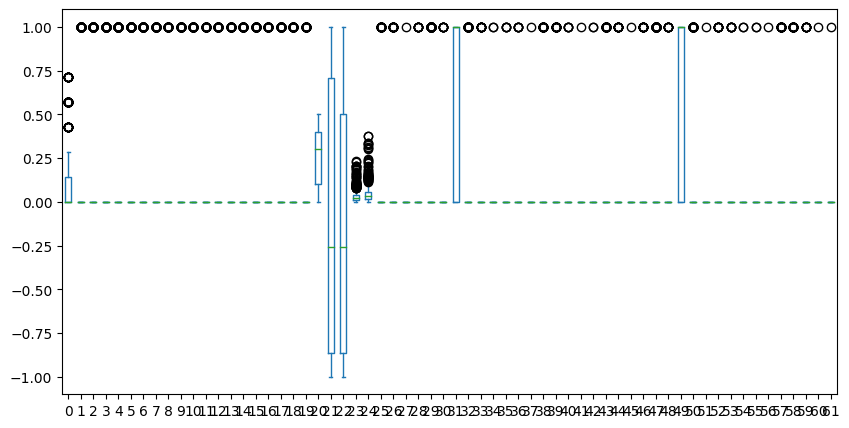

In [327]:
fig, ax = plt.subplots(figsize=(10, 5))
pd.DataFrame(X_train_processed).plot(kind='box', ax=ax);

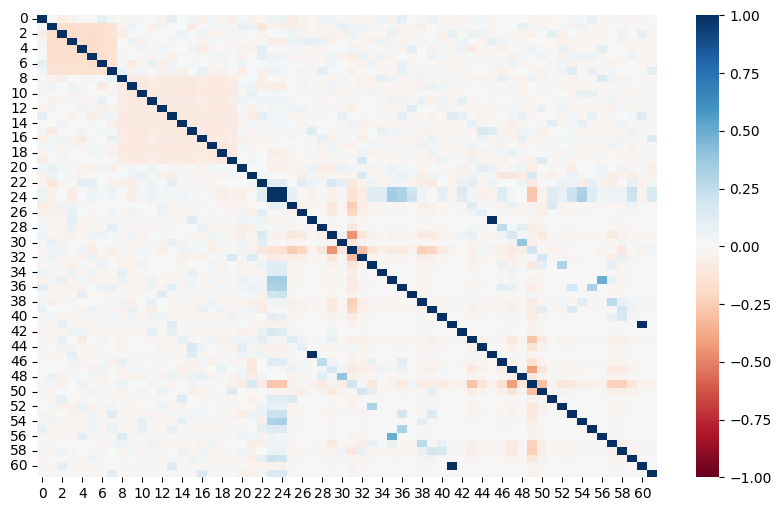

In [328]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(pd.DataFrame(X_train_processed).corr(), vmin=-1, cmap='RdBu');

To conclude, we compress our data to float32

In [329]:
X_train_processed.dtype

dtype('float64')

In [330]:
print(X_train_processed.nbytes / 1024**2, "MB")

0.3211822509765625 MB


In [331]:
# Compress the data a bit
X_train_processed = X_train_processed.astype(np.float32)
print(X_train_processed.nbytes / 1024**2, "MB")

0.16059112548828125 MB


In [332]:
pd.DataFrame(X_train_processed)

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.142857,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.142857,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.142857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.285714,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
675,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
676,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
677,0.285714,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


☝️ The preprocessor outputs a **fixed** number of features (65) that is independent of the training set. 

☝️ The preprocessor is also  **state-less** (i.e it has no `.fit()` method, only a `.transform()`). It can be seen as a *pure function* $f:X \rightarrow X_{processed}$ without an internal state, as opposed to standard scaling for instance, which has to store "X_train standard deviations" as internal states.

These two features will make work much easier for the ML Engineering team to scale preprocessing to hundreds of GBs. 

# 3) Model

❓ To begin with, please install `tensorflow` >=2.8 on your `taxifare-env`

For instance, you can add one of the following lines to `requirements.txt`

```
tensorflow-macos==2.10.0 ; sys_platform == "darwin"
tensorflow==2.10.0 ; sys_platform == "linux"
```

And then `pip install -e .` to install it on `taxifare-env`



## 3.1) Architecture

In [366]:
from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [367]:
def initialize_model(X: np.ndarray) -> Model:
    """
    Initialize the Neural Network with random weights
    """

    reg = regularizers.l1_l2(l2=0.01)

    model = Sequential()
    model.add(layers.BatchNormalization(input_shape=X.shape[1:]))
    model.add(layers.Dense(100, activation="relu", kernel_regularizer=reg, input_shape=X.shape[1:]))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(50, activation="relu", kernel_regularizer=reg))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.BatchNormalization(momentum=0.99)) # use momentum=0 for to only use statistic of the last seen minibatch in inference mode ("short memory"). Use 1 to average statistics of all seen batch during training histories.
    
    model.add(layers.Dense(1, activation="linear"))

    print("✅ model initialized")

    return model

In [368]:
model = initialize_model(X_train_processed)
model.summary()

✅ model initialized
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 62)               248       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 100)               6300      
                                                                 
 batch_normalization_9 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 batch_normalization_10 (Bat  (None, 50)               200       
 chNormalization)                                                
                                  

In [369]:
learning_rate = 0.001
batch_size = 256

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

In [370]:
es = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=0
)

history = model.fit(
    X_train_processed,
    y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
2/2 [==============================] - 2s 259ms/step - loss: 201.7488 - mae: 10.8800 - val_loss: 184.8919 - val_mae: 10.5047
Epoch 2/100
2/2 [==============================] - 0s 30ms/step - loss: 196.2844 - mae: 10.8685 - val_loss: 184.4978 - val_mae: 10.4885
Epoch 3/100
2/2 [==============================] - 0s 37ms/step - loss: 192.1555 - mae: 10.8571 - val_loss: 184.1415 - val_mae: 10.4742
Epoch 4/100
2/2 [==============================] - 0s 34ms/step - loss: 188.6541 - mae: 10.8456 - val_loss: 183.8285 - val_mae: 10.4623
Epoch 5/100
2/2 [==============================] - 0s 38ms/step - loss: 185.2735 - mae: 10.8340 - val_loss: 183.5719 - val_mae: 10.4536
Epoch 6/100
2/2 [==============================] - 0s 37ms/step - loss: 182.9165 - mae: 10.8224 - val_loss: 183.3615 - val_mae: 10.4470
Epoch 7/100
2/2 [==============================] - 0s 38ms/step - loss: 179.4062 - mae: 10.8108 - val_loss: 183.2260 - val_mae: 10.4441
Epoch 8/100
2/2 [==============================

## 3.2) Performance evaluation

In [371]:
X_test_processed = final_preprocessor.transform(X_test)

In [377]:
X_test_processed.shape

(291, 62)

In [372]:
y_pred = model.predict(X_test_processed)
y_pred

10/10 [==============================] - 0s 1ms/step


array([[ 0.08857551],
       [ 0.15636057],
       [ 0.14549091],
       [-0.03446135],
       [ 0.12178145],
       [ 0.09207125],
       [ 0.0530633 ],
       [ 0.0811747 ],
       [ 0.0247008 ],
       [ 0.03982731],
       [ 0.05880604],
       [ 0.01794693],
       [-0.14099272],
       [-0.07169889],
       [ 0.04385238],
       [ 0.0150955 ],
       [ 0.00860918],
       [ 0.16999888],
       [-0.21309519],
       [ 0.0295951 ],
       [ 0.08489382],
       [ 0.01197078],
       [ 0.14809322],
       [-0.26706576],
       [-0.02546499],
       [-0.09148225],
       [-0.24660751],
       [ 0.00308731],
       [ 0.01084693],
       [ 0.04617418],
       [ 0.04786116],
       [ 0.20098303],
       [-0.12994371],
       [ 0.02202822],
       [-0.09005843],
       [ 0.15413824],
       [ 0.1590774 ],
       [ 0.04569127],
       [-0.17316386],
       [ 0.13060652],
       [ 0.04859713],
       [ 0.06869157],
       [-0.01543477],
       [ 0.0988913 ],
       [ 0.0750075 ],
       [ 0

In [340]:
model.evaluate(X_test_processed, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 217.5345 - mae: 11.3415


[217.53448486328125, 11.341543197631836]

(0.0, 60.0)

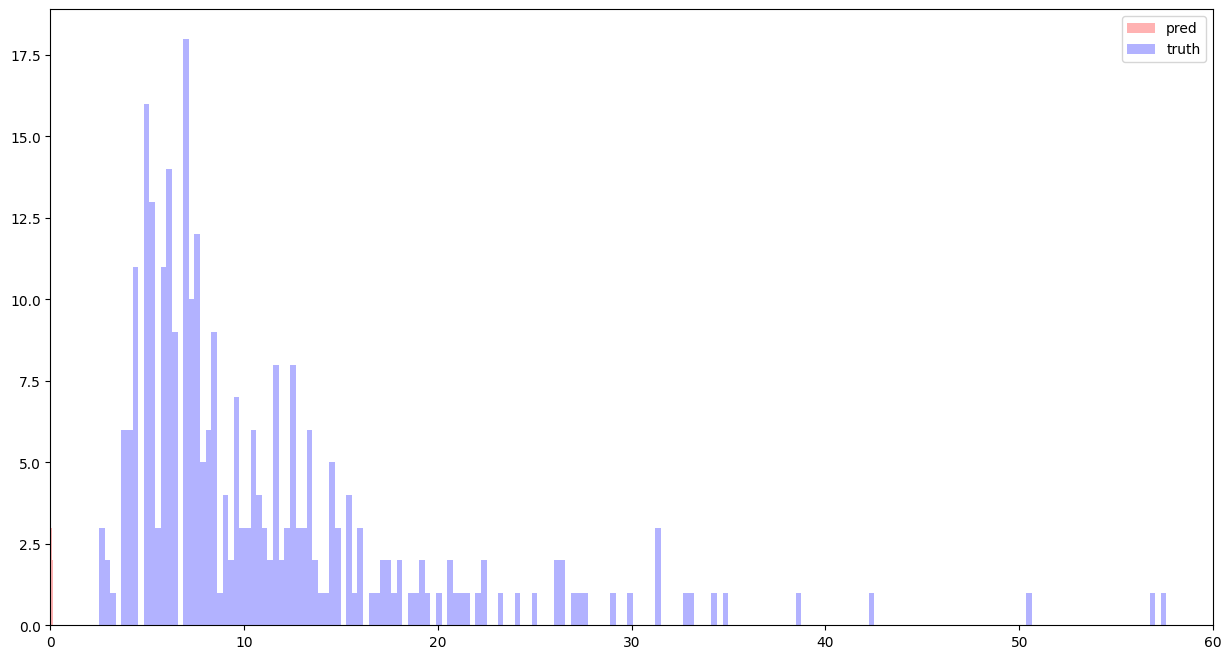

In [341]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

plt.hist(y_pred, label='pred', color='r', bins=200, alpha=0.3)
plt.hist(y_test, label='truth', color='b', bins=200, alpha=0.3)

plt.legend()
plt.xlim((0,60))

In [342]:
residuals = y_pred - y_test

In [343]:
residuals.describe()

,fare_amount
count,291.000000
mean,-11.341543
std,8.779582
min,-60.423748
25%,-13.253699
50%,-8.260533
75%,-5.915058
max,-2.337367


(-20.0, 20.0)

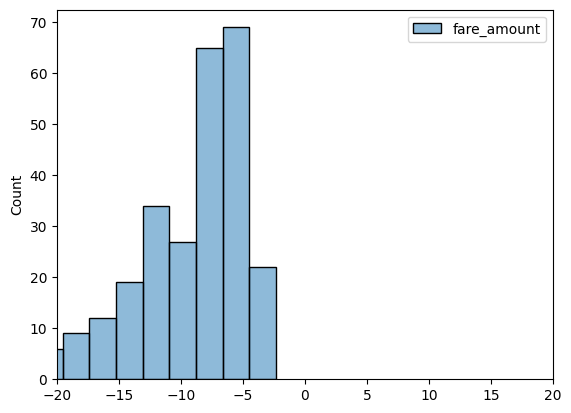

In [344]:
residuals = y_pred - y_test
sns.histplot(residuals)
plt.xlim(xmin=-20, xmax=20)

In [345]:
residuals.sort_values(by='fare_amount')

,fare_amount
546,-60.423748
792,-57.232910
951,-56.739948
989,-50.449875
280,-42.402859
...,...
825,-3.057664
359,-2.922219
712,-2.565127
999,-2.421858


Text(0, 0.5, 'residuals')

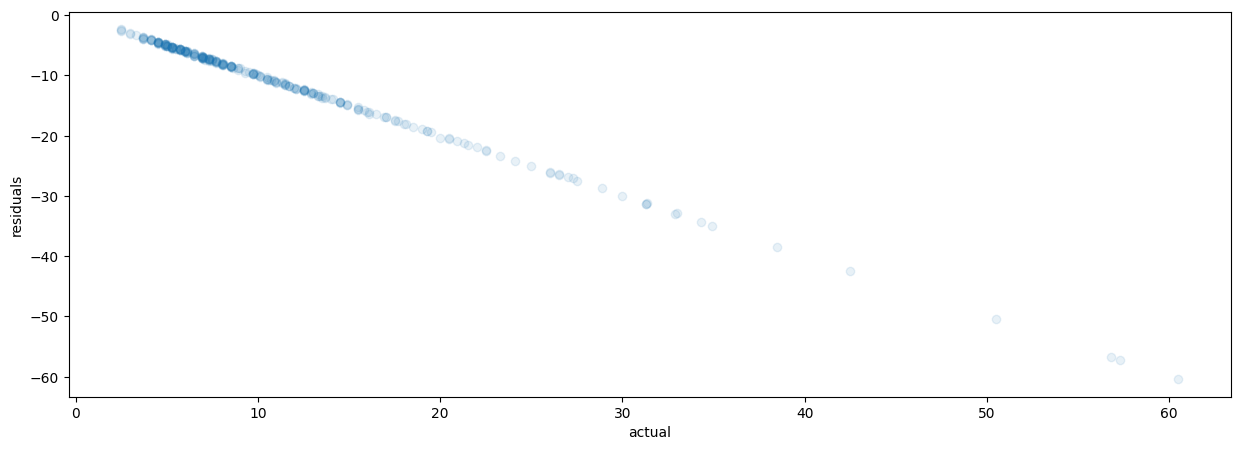

In [346]:
# Residual vs. actual scatter plot
plt.figure(figsize=(15,5))
plt.scatter(x=y_test,y=residuals, alpha=0.1)
plt.xlabel('actual')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

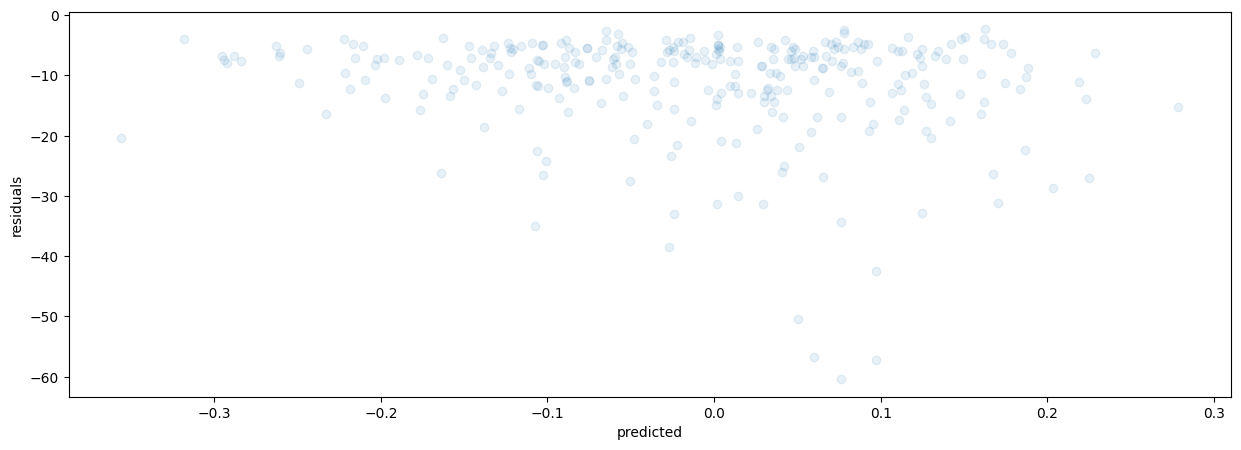

In [347]:
# Residual vs. predicted scatter plot
plt.figure(figsize=(15,5))
plt.scatter(x=y_pred,y=residuals, alpha=0.1)
plt.xlabel('predicted')
plt.ylabel('residuals')

☝️ Our model has an MAE of about 2$ per course, compared with a mean course price of 11$.  

A simple linear regression would give us about 2.5$ of MAE, but the devil lies in the details!

In particular, we're not that good at predicting very long/expensive courses

# 🧪 Test Your Understanding

❓ Try to answer these questions with your buddy
1. Are you satisfied with the model's performance?
2. What is a stateless pipeline (as opposed to a stateful one)?
3. How does an OHEncoder work with fixed column categories?
4. How is the data normalization done in the Neural Net?

<details>
  <summary markdown='span'>💡 Answers</summary>

1. We have a 25% improvement over the linear regression baseline, and it seems that our model has been doing its best, given the features it has been provided with. Besides, a 2$ forecast error on taxi courses whose prices also depend on traffic seems close to the irreducible error rate.
2. A stateless pipeline has no real `.fit()` method, only a `.transform()`. 
3. To become stateless, we've hard-coded the `categories` to one-hot encode `OneHotEncoder(categories=categories,...)` and hard-coded the statistical features of each column in our scalers:  `FunctionTransformer(lambda dist: (dist - dist_min)/(dist_max - dist_min))`
4. In the TensorFlow model, notice the `layers.BatchNormalization()` we've added between each dense layer, which normalizes data batch-per-batch! It's a cool feature to help fix vanish gradients during the back-propagation!
</details>

❓ Predict the price for this new course `X_new` below and store the result `y_new` as a `np.ndarray`

In [388]:
X_new = pd.DataFrame(dict(
    key=["2013-07-06 17:18:00"],  # useless but the pipeline requires it
    pickup_datetime=["2013-07-06 17:18:00 UTC"],
    pickup_longitude=[-73.950655],
    pickup_latitude=[40.783282],
    dropoff_longitude=[-73.984365],
    dropoff_latitude=[40.769802],
    passenger_count=[1]
))

X_new

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2013-07-06 17:18:00,2013-07-06 17:18:00 UTC,-73.950655,40.783282,-73.984365,40.769802,1


In [389]:
X_new_processed = final_preprocessor.transform(X_new)

In [390]:
X_new_processed.shape

(1, 62)

In [376]:
y_new = model.predict(X_new_processed)
y_new[0][0]

1/1 [==============================] - 0s 24ms/step


0.10938804

In [352]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'notebook',
    subdir='train_at_scale',
    y_new=y_new
)

result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.2.0, pluggy-1.0.0 -- /Users/bingobango/.pyenv/versions/3.10.6/envs/taxifare-env/bin/python3
cachedir: .pytest_cache
rootdir: /Users/bingobango/code/lewagon/data-train-at-scale, configfile: pytest.ini
plugins: anyio-3.6.2
collecting ... collected 1 item

test_notebook.py::TestNotebook::test_y_pred PASSED                       [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/train_at_scale/notebook.pickle

git commit -m 'Completed notebook step'

git push origin master

